# Data exploration - Wikispeedia

## Import

In [1]:
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

import os
import random 

## Load data

### Load tsv files

In [2]:
DATA_PATH = 'data/wikispeedia_paths-and-graph/'

# load tsv files into pandas dataframes
articles = pd.read_csv(os.path.join(DATA_PATH, 'articles.tsv'), sep='\t', comment='#', names=['article'])
categories = pd.read_csv(os.path.join(DATA_PATH, 'categories.tsv'), sep='\t', comment='#', names=['article', 'category'])
links = pd.read_csv(os.path.join(DATA_PATH, 'links.tsv'), sep='\t', comment='#', names=['linkSource', 'linkTarget'])
path_finished = pd.read_csv(os.path.join(DATA_PATH, 'paths_finished.tsv'), sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
path_unfinished = pd.read_csv(os.path.join(DATA_PATH, 'paths_unfinished.tsv'), sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])

# print lengths of dataframes
print('articles:', len(articles))
print('categories:', len(categories))
print('links:', len(links))
print('path_finished:', len(path_finished))
print('path_unfinished:', len(path_unfinished))

articles: 4604
categories: 5204
links: 119882
path_finished: 51318
path_unfinished: 24875


In [3]:
articles.sample(n=5)

,article
2181,Italian_War_of_1521
238,Anarcho-capitalism
3430,Rama
157,Akhenaten
3711,Sheikh_Mujibur_Rahman


In [4]:
categories.sample(n=5)

,article,category
2150,Henry_II_of_England,subject.History.British_History.British_Histor...
619,Benjamin_Disraeli%2C_1st_Earl_of_Beaconsfield,subject.People.Political_People
4591,The_Lion_King,subject.Everyday_life.Films
5042,Whale_song,subject.Science.Biology.Mammals
1325,Demosthenes,subject.People.Historical_figures


In [5]:
links.sample(n=5)

,linkSource,linkTarget
67197,Los_Angeles%2C_California,Indonesia
46061,Great_Black-backed_Gull,Europe
29822,Decade_Volcanoes,Volcano
106723,The_Famous_Five_%28characters%29,Nazi_Germany
56665,Isle_of_Man,Latin


In [6]:
path_finished.sample(n=5)

,hashedIpAddress,timestamp,durationInSec,path,rating
6381,3804c89b7c37debb,1362173987,173,Music;Aesthetics;Architecture;Industrial_Revol...,NaN
12277,656628c22d882e9e,1300878009,72,Asteroid;Earth;Europe;Ireland;Viking,NaN
43247,654fc5e419e5c364,1269958631,93,Miranda_Otto;William_Shakespeare;England;Histo...,3.0
33833,319fa3ca523412a2,1299421305,315,Aberration_of_light;Galileo_Galilei;Pope_John_...,3.0
10664,3dd9b0b529a98b0d,1259882688,152,Dubai;People%27s_Republic_of_China;China;Chine...,NaN


In [7]:
path_unfinished.sample(n=5)

,hashedIpAddress,timestamp,durationInSec,path,target,type
19820,33910ec31fee594d,1371418725,31,Sun,Moon,restart
9156,1fcfb9191ca1b595,1340232566,85,Go_%28board_game%29;Board_game;Game;Computer;I...,Medal_of_Honor,restart
17168,3804c89b7c37debb,1361462164,1806,Mass_media,George_Washington,timeout
7300,1435204c44915446,1328054932,145,Zeus;Religion;Judaism;Olive_oil,Humus,restart
23598,282a310d5b141fd2,1385064844,19,Eyelid,ITunes,restart


### Graph analysis

In [11]:
# create a graph with links dataframe
G = nx.DiGraph()
G.add_nodes_from(articles['article'])

for i, row in links.iterrows():
    G.add_edge(row['linkSource'], row['linkTarget'])    

In [12]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
print(f"Average out-degree: {sum(dict(G.out_degree()).values()) / G.number_of_nodes():.2f}")
print(f"Average in-degree: {sum(dict(G.in_degree()).values()) / G.number_of_nodes():.2f}")

Number of nodes: 4604
Number of edges: 119882
Average degree: 52.08
Average out-degree: 26.04
Average in-degree: 26.04


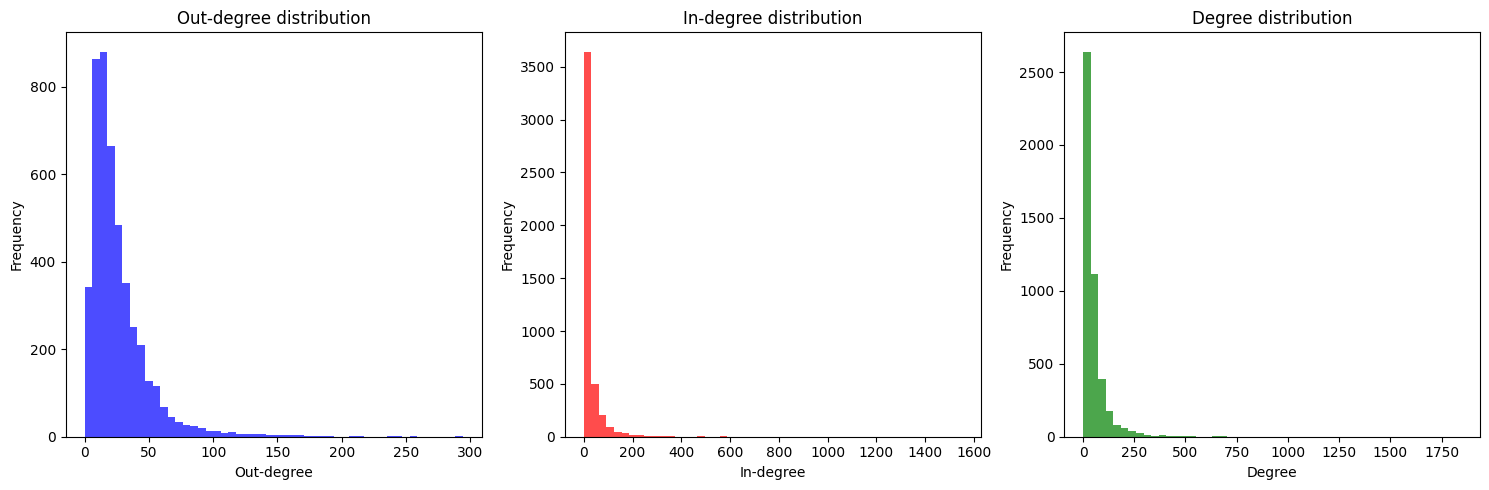

In [15]:
# plot the out-degree, in-degree and degree distributions
out_degrees = dict(G.out_degree())
in_degrees = dict(G.in_degree())
degrees = dict(G.degree())

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(list(out_degrees.values()), bins=50, color='b', alpha=0.7)
plt.xlabel('Out-degree')
plt.ylabel('Frequency')
plt.title('Out-degree distribution')

plt.subplot(1, 3, 2)
plt.hist(list(in_degrees.values()), bins=50, color='r', alpha=0.7)
plt.xlabel('In-degree')
plt.ylabel('Frequency')
plt.title('In-degree distribution')

plt.subplot(1, 3, 3)
plt.hist(list(degrees.values()), bins=50, color='g', alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree distribution')

plt.tight_layout()
plt.show()

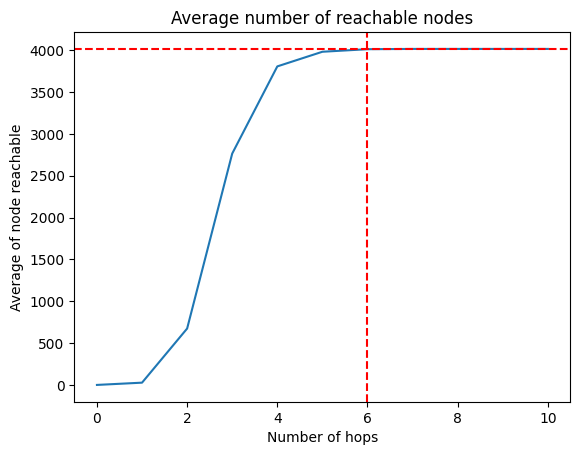

In [16]:
# check if it is a small world

def plot_distribution_path_length(G, n_samples=100, start_hops=0, n_hops=10):
    """
    Plots the distribution of reachable nodes within a given number of hops in a graph, 
    based on a sample of nodes.

    Parameters:
        - G (networkx.Graph): The graph to analyze.
        - n_samples (int, optional): The number of nodes to sample.
        - start_hops (int, optional): The starting number of hops.
        - n_hops (int, optional): The maximum number of hops.
    Returns:
        - None
    """

    assert start_hops <= n_hops
    sampled_nodes = random.sample(list(G.nodes) ,n_samples)
    G_sampled = G.subgraph(sampled_nodes)
    
    average_reachable_nodes = {}

    # to see the intersection of the average reachable nodes at 6 hops
    intersection_hops_6 = 0

    for i in range(start_hops,n_hops+1):
        average_reachable_nodes[i] = np.mean([len(nx.single_source_shortest_path_length(G, node, cutoff=i)) for node in G_sampled.nodes()])
        
        if i == 6:
            intersection_hops_6 = average_reachable_nodes[i]

    average_reachable_nodes = average_reachable_nodes.items()
    x,y = zip(*average_reachable_nodes)

    plt.plot(x,y)
    plt.xlabel('Number of hops')
    plt.ylabel('Average of node reachable')
    plt.title('Average number of reachable nodes')
    plt.axhline(y=intersection_hops_6, color='r', linestyle='--')
    plt.axvline(x=6, color='r', linestyle='--')
    plt.show()

plot_distribution_path_length(G, n_samples=100, start_hops=0, n_hops=10)